In [1]:
from PINNs import Bound, PhysicsBound, PINN, NVS, NetworkTrainer, Visualization
import torch
import matplotlib.pyplot as plt

ImportError: cannot import name 'PhysicsBound' from 'PINNs' (C:\Users\thamm\OneDrive\Documents\1 - Projects\0 - STEM\2 - Numerical Physics\9 - PINNs\PINNs-for-NVS-fluid\src\PINNs\__init__.py)

## 1. Define Physical Space

Define physical bound

In [ ]:
# Define the channel geometry boundaries

# Manualy define bound
# bound_list = [
#     Bound([0, 10], lambda x: 1 * torch.ones_like(x), True),  # Top wall
#     Bound([0, 10], lambda x: 0 * torch.ones_like(x), False), # Bottom wall
#     Bound([0.00001, 0.99999], lambda y: 0 * torch.ones_like(y), False, ref_axis='y'), # Inlet
#     Bound([0, 1], lambda y: 10 * torch.ones_like(y), True, ref_axis='y') # Outlet
# ]

# Automatically define bound
bound_list = Bound.create_rectangle_bound([0,5],[0,1])


Plot Physical bound

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


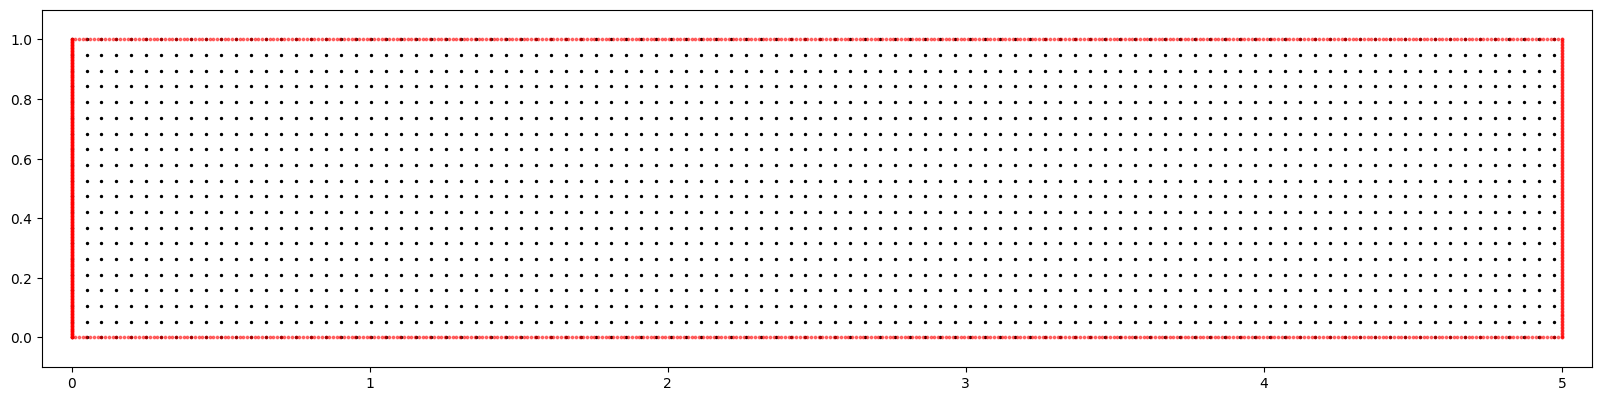

In [ ]:
X, Y = Bound.sampling_area(bound_list, [200,20], [0,10], [0,1])

sampling_resolution_list = [400, 400, 400, 200]

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=2, color='black')
for i,bound in enumerate(bound_list):
    x,y = bound.sampling_line(sampling_resolution_list[i])
    plt.scatter(x,y,s=3, color='red', alpha=0.5)
plt.xlim(-0.1,5.1)
plt.ylim(-0.1,1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Define Boundary Conditions and PDE Area

In [ ]:
# Define the physics at the boundaries
physics_cond_list = [
    {'u': 0.0, 'v': 0.0},      # Top wall: No-slip
    {'u': 0.0, 'v': 0.0},      # Bottom wall: No-slip
    {'u': ['y', lambda y:  4*1*(1-y)*y/1**2] , 'v': 0.0},      # Inlet: Parabolic inflow
    {'p': 0.0}                 # Outlet: Zero pressure
]

# Create a list of boundary condition objects and define the PDE area
boundary_conditions_list = [
    PhysicsBound.define_boundary_condition(bound, cond) 
    for bound, cond in zip(bound_list, physics_cond_list)
]
# Define PDE area
area_physics_bound = PhysicsBound.define_pde_area(
    bound_list=bound_list, 
    sampling_range_x=[0, 5], 
    sampling_range_y=[0, 1], 
    PDE_class=NVS()
)

### Sampling points

In [ ]:
# Define sampling resolutions and sampling function
sampling_resolution_list = [400, 400, 400, 200]
area_sampling_resolution = 4860

# def uniform_sampling():
#     for i,bc in enumerate(boundary_conditions_list):
#         bc.sampling_collocation_points(sampling_resolution_list[i])
#     area_physics_bound.sampling_collocation_points([44,220])

n = 0
sampling_frequency = 300
def random_sampling(bound_sampling_resolution_list, area_sampling_resolution):
    global n, sampling_frequency
    if n%sampling_frequency==0 or n==0:
        print('sampling')
        for i, bc in enumerate(boundary_conditions_list):
            bc.sampling_collocation_points(bound_sampling_resolution_list[i], random=True)
        area_physics_bound.sampling_collocation_points(area_sampling_resolution, random=True)
    n += 1
area_sampling_resolution = 486

## Define the Model and Loss Function

In [ ]:
model0 = PINN(width=32, length=8)

In [ ]:
# Define the loss calculation function
loss_fn = torch.nn.MSELoss()
def calc_loss(model):
    # Re-sample the collocation points at each step
    random_sampling(sampling_resolution_list,area_sampling_resolution)

    # BC Loss
    bc_loss = 0
    for i, bc in enumerate(boundary_conditions_list):
        bc_loss += bc.calc_loss(model, loss_fn)

    # PDE Loss
    pde_loss = area_physics_bound.calc_loss(model)
    
    # Total Loss
    total_loss = bc_loss + pde_loss
    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [ ]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=3000,
    print_every=100
)

sampling
epoch 1, total_loss: 0.40035, bc_loss: 0.40034, pde_loss: 0.00001
epoch 101, total_loss: 0.09548, bc_loss: 0.08575, pde_loss: 0.00974
sampling
epoch 201, total_loss: 0.04899, bc_loss: 0.03071, pde_loss: 0.01828
epoch 301, total_loss: 0.00685, bc_loss: 0.00181, pde_loss: 0.00504
sampling
epoch 401, total_loss: 0.00064, bc_loss: 0.00016, pde_loss: 0.00048
epoch 501, total_loss: 0.00024, bc_loss: 0.00010, pde_loss: 0.00014
sampling
epoch 601, total_loss: 0.00008, bc_loss: 0.00003, pde_loss: 0.00005
epoch 701, total_loss: 0.00011, bc_loss: 0.00006, pde_loss: 0.00005
sampling
epoch 801, total_loss: 0.00005, bc_loss: 0.00001, pde_loss: 0.00003
epoch 901, total_loss: 0.00005, bc_loss: 0.00001, pde_loss: 0.00003
sampling
epoch 1001, total_loss: 0.00368, bc_loss: 0.00333, pde_loss: 0.00035
epoch 1101, total_loss: 0.00004, bc_loss: 0.00001, pde_loss: 0.00003
sampling
epoch 1201, total_loss: 0.00170, bc_loss: 0.00149, pde_loss: 0.00021
epoch 1301, total_loss: 0.00004, bc_loss: 0.00001, p

Continue training with higher sampling rate

In [ ]:
sampling_resolution_list = [400, 400, 400, 200]
area_sampling_resolution = 4860

In [ ]:
# For better results, continue training with a smaller learning rate
model2 = NetworkTrainer.train_adam(
    model=model1, 
    calc_loss=calc_loss, 
    learning_rate=0.0005, 
    epochs=1000, 
    print_every=100
)

sampling
epoch 3001, total_loss: 0.00003, bc_loss: 0.00001, pde_loss: 0.00002
epoch 3101, total_loss: 0.00006, bc_loss: 0.00003, pde_loss: 0.00003
sampling
epoch 3201, total_loss: 0.00004, bc_loss: 0.00001, pde_loss: 0.00002
epoch 3301, total_loss: 0.00003, bc_loss: 0.00001, pde_loss: 0.00002
sampling
epoch 3401, total_loss: 0.00003, bc_loss: 0.00001, pde_loss: 0.00002
epoch 3501, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00002
sampling
epoch 3601, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00001
epoch 3701, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00001
sampling
epoch 3801, total_loss: 0.00002, bc_loss: 0.00001, pde_loss: 0.00001
epoch 3901, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001


## 3. Visualize the Results

In [ ]:
# Create visualization object
visual_model = Visualization(area_physics_bound, model2)
visual_model.sampling_plot_points(800,80)
keyword = visual_model.process_model()
print(keyword) #printing keyword using for plotclor_select()

5.0
(['u', 'v', 'p', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'residual', 'velocity_magnitude'], ['total_loss', 'bc_loss', 'pde_loss'])


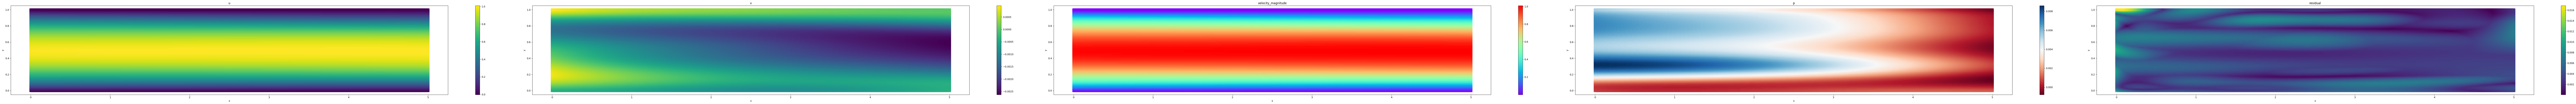

In [ ]:
cmap_dict = {
    'u':None,
    'v':None,
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
    'residual':None
}
colorplot_all = visual_model.plotcolor_select(cmap_dict)
colorplot_all.savefig('channel_flow_steady_all.png')

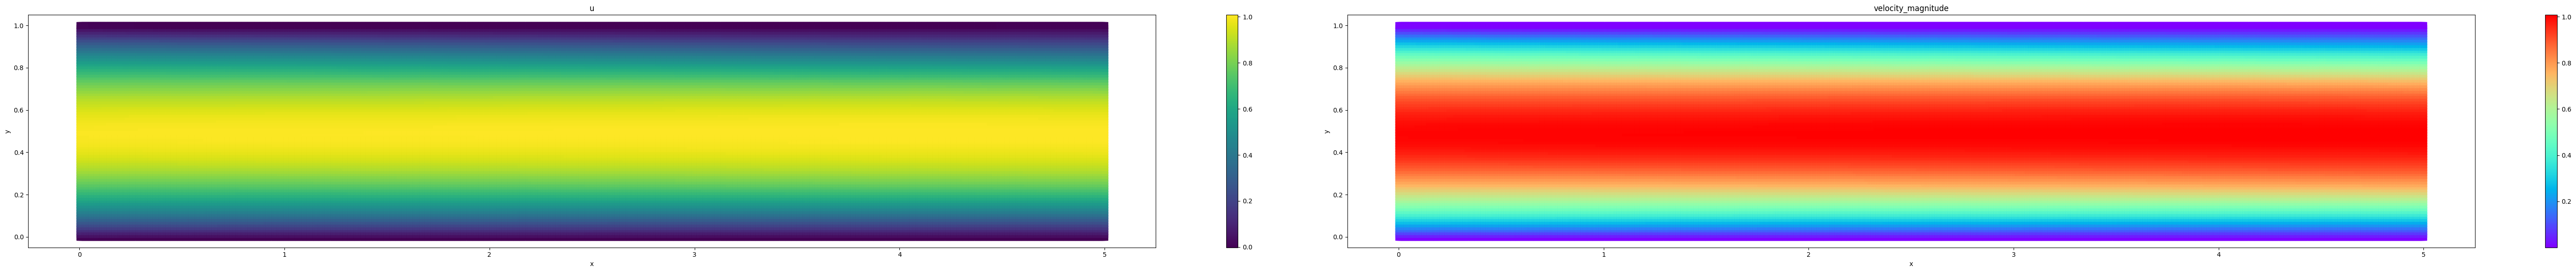

In [ ]:
cmap_dict = {'u':None, 'velocity_magnitude': 'rainbow'}
colorplot = visual_model.plotcolor_select(cmap_dict)
colorplot.savefig('channel_flow_steady.png')

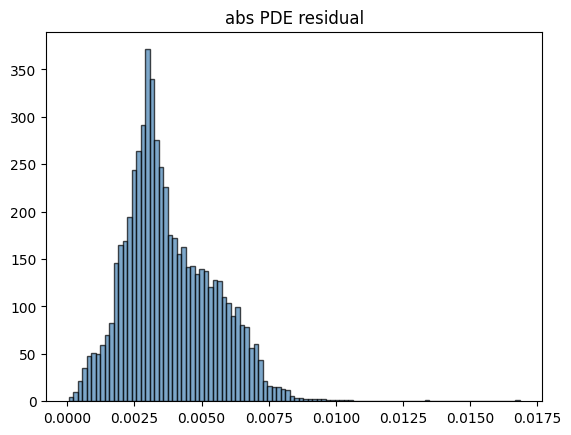

In [ ]:
residual_plot = visual_model.plot_residual_distribution()
residual_plot.savefig('residual.png')

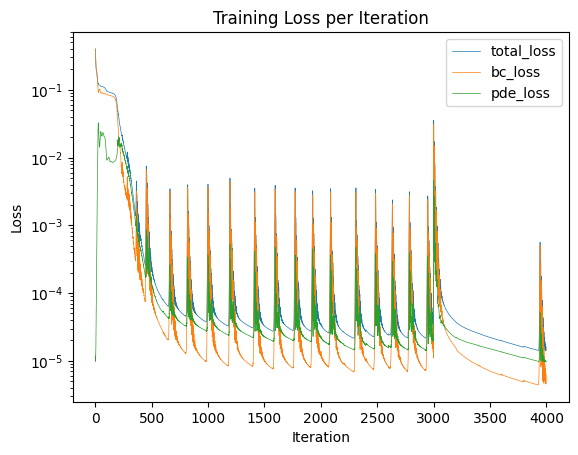

In [ ]:
residual_plot = visual_model.plot_loss_evolution(log_scale=True, linewidth=0.5)
residual_plot.savefig('loss_evolution.png')

## Visualization without tools

In [ ]:
import numpy as np
import PINNs
area_physics_bound.sampling_collocation_points([400,40])
area_physics_bound.process_model(model2)
area_physics_bound.process_pde()
X,Y,T = area_physics_bound.model_inputs.values()
U,V,P = area_physics_bound.model_outputs.values()
residual = area_physics_bound.PDE.calc_residual_sum()
X,Y,U,V,P,residual = PINNs.torch_to_numpy(X,Y,U,V,P,residual)
V_size = np.sqrt(U**2+V**2)


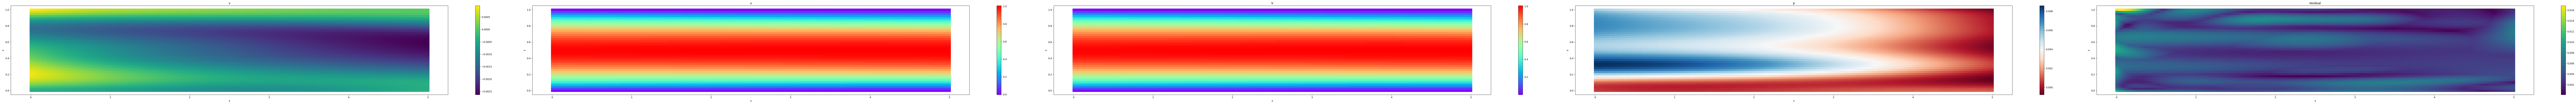

In [ ]:
from PINNs import Visualization
fig, axes = plt.subplots(1,5, figsize=(6*5*5,6))
s =80
Visualization.colorplot(X.flatten(),Y.flatten(),V.flatten(),axes[0],'v','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),U.flatten(),axes[1],'u','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),V_size.flatten(),axes[2],'V','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),P.flatten(),axes[3],'p','RdBu',s)
Visualization.colorplot(X.flatten(),Y.flatten(),residual.flatten(),axes[4],'residual','viridis',s)
plt.tight_layout()
plt.show()

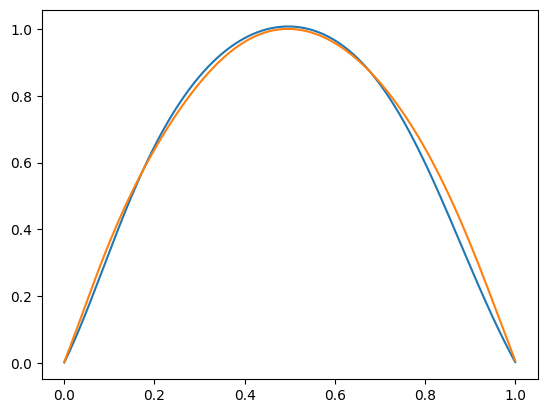

In [ ]:
outlet_bound = boundary_conditions_list[3]
outlet_bound.sampling_collocation_points(1000)
outlet_bound.pde_define(NVS())
outlet_bound.process_model(model1)
outlet_bound.process_pde()
X,Y,T = outlet_bound.model_inputs.values()
U,V,P = outlet_bound.model_outputs.values()
X,Y,U,P,V = PINNs.torch_to_numpy(X,Y,U,V,P)

plt.plot(Y.flatten(), U.flatten())

outlet_bound = boundary_conditions_list[2]
outlet_bound.sampling_collocation_points(1000)
outlet_bound.pde_define(NVS())
outlet_bound.process_model(model1)
outlet_bound.process_pde()
X,Y,T = outlet_bound.model_inputs.values()
U,V,P = outlet_bound.model_outputs.values()
X,Y,U,P,V = PINNs.torch_to_numpy(X,Y,U,V,P)

plt.plot(Y.flatten(), U.flatten())
plt.show()

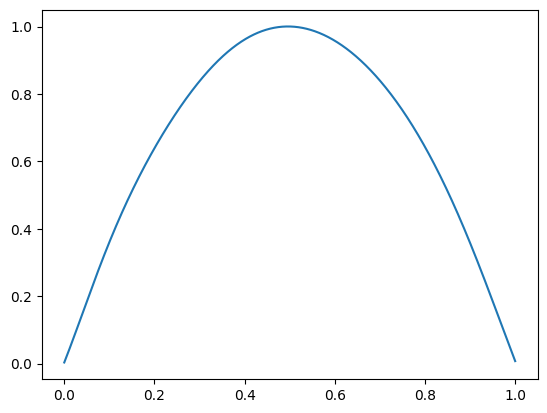

In [ ]:
outlet_bound = boundary_conditions_list[2]
outlet_bound.sampling_collocation_points(1000)
outlet_bound.pde_define(NVS())
outlet_bound.process_model(model1)
outlet_bound.process_pde()
X,Y,T = outlet_bound.model_inputs.values()
U,V,P = outlet_bound.model_outputs.values()
X,Y,U,P,V = PINNs.torch_to_numpy(X,Y,U,V,P)

plt.plot(Y.flatten(), U.flatten())
plt.show()